# **Setup**

In [ ]:
!git clone https://github.com/Lamdtom/GenderDefiner.git
%cd GenderDefiner

: 

In [1]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, models, transforms
from resnet import Bottleneck, ResNet, ResNet18, ResNet50, ResNet101, ResNet152
import matplotlib.pyplot as plt
import time
import os
import numpy as np
import copy
import logging
from imutils import paths
import cv2
#from google.colab.patches import cv2_imshow

# **Data Validation**

# **Blur Detection**

In [7]:
#Waring will remove all pictures that are considered blurry 
#The file should be saved to one cloud before continuing

def variance_of_laplacian(image):
    # compute the Laplacian of the image and then return the focus
    # measure, which is simply the variance of the Laplacian
    return cv2.Laplacian(image, cv2.CV_64F).var()

def blur_detect(path):
    # loop over the input images
    for imagePath in paths.list_images(path):
      # load the image, convert it to grayscale, and compute the
      # focus measure of the image using the Variance of Laplacian
      # method
      image = cv2.imread(imagePath)
      image = cv2.resize(image, (96, 96))
      gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
      fm = variance_of_laplacian(gray)

      # if the focus measure is less than the supplied threshold,
      # then the image should be considered "blurry"
      if fm < threshold:
        os.remove(imagePath)

      # show the image


threshold = 400
path = 'data'
blur_detect(path)

# **Bright Detection**

In [ ]:
#Currently, this does't work correctly
'''
def bright_detection(path):
    for imagePath in paths.list_images(path):
        image = cv2.imread(imagePath)
        image = cv2.resize(image, (96, 96))
        blur = cv2.blur(image, (5, 5))  # With kernel size depending upon image size
        print(np.mean(blur))
        if np.mean(blur) > 127:  # The range for a pixel's value in grayscale is (0-255), 127 lies midway
            print('Light')
        else:
            print('Dark')
        cv2_imshow(image)
path = 'data/test'
bright_detection(path)
'''

Output hidden; open in https://colab.research.google.com to view.

# **Data augmentation**

In [2]:
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize(96),
        transforms.RandomResizedCrop(64),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'valid': transforms.Compose([
        transforms.Resize(96),
        transforms.CenterCrop(64),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(96),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

In [3]:
def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % 2**32
    np.random.seed(worker_seed)

g = torch.Generator()
g.manual_seed(0)

# **Load in Data**

In [4]:
data_dir = 'data'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'valid', 'test']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=32,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'valid', 'test']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'valid', 'test']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

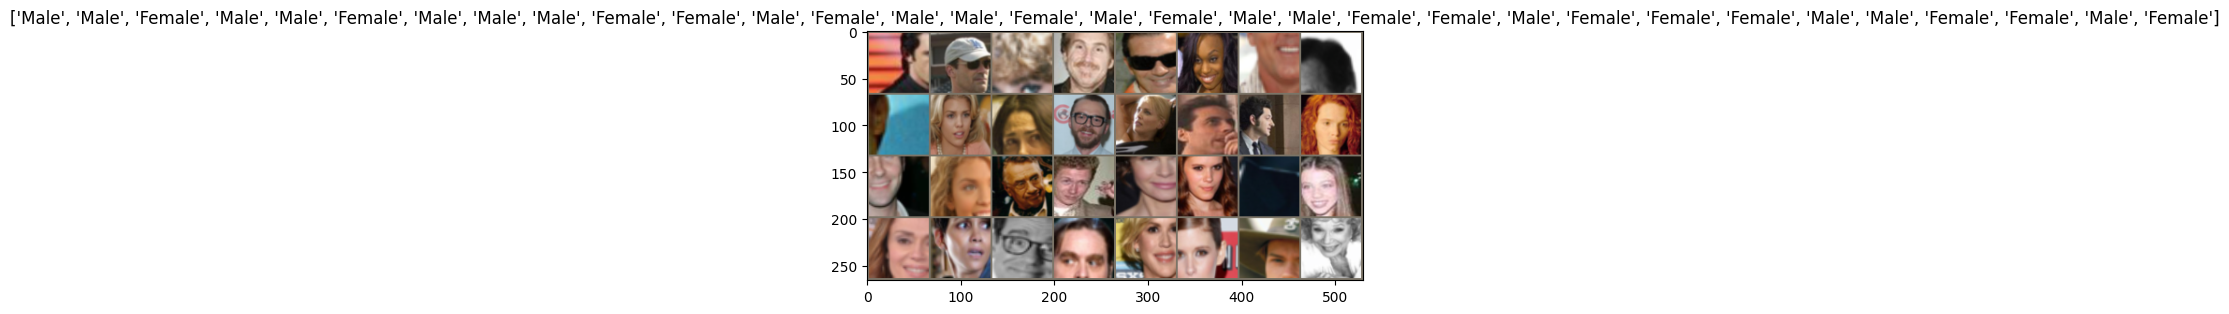

In [5]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

# **Training model**

In [6]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch + 1}/{num_epochs}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'valid']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()
                

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            #if phase == 'train':
            #    metrics['train_loss'].append(epoch_loss)

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # deep copy the model
            if phase == 'valid' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
                torch.save(model.state_dict(), os.path.join('checkpoints', f'DefineGenderBest.pth'))
                logging.info(f'Best Checkpoint saved !')
            '''
            if (epoch + 1) % 10 == 0:
                try:
                    os.mkdir('checkpoints')
                    logging.info('Created checkpoint directory')
                except OSError:
                    pass
                torch.save(model.state_dict(), os.path.join('checkpoints', f'DefineGender{epoch + 1}.pth'))
                logging.info(f'Checkpoint {epoch + 1} saved !')
          '''

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best valid Acc: {best_acc:4f}')

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [7]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['test']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

# **Setup model**

In [8]:
net = ResNet18(2).to('cuda')
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(net.parameters(), lr=0.001, weight_decay=0.0001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)
#pretrained_dict = torch.load('checkpoints/DefineGenderBest3.pth', map_location=torch.device('cuda'))
#net.load_state_dict(pretrained_dict)

# **Training**

In [9]:
model_ft = train_model(net, criterion, optimizer, scheduler,
                       num_epochs=30)


Epoch 1/30
----------
train Loss: 0.7120 Acc: 0.6320
valid Loss: 0.5983 Acc: 0.7071

Epoch 2/30
----------
train Loss: 0.6486 Acc: 0.6765
valid Loss: 0.5627 Acc: 0.7403

Epoch 3/30
----------
train Loss: 0.5829 Acc: 0.6963
valid Loss: 0.5123 Acc: 0.7830

Epoch 4/30
----------
train Loss: 0.5392 Acc: 0.7285
valid Loss: 0.5208 Acc: 0.7324

Epoch 5/30
----------
train Loss: 0.5427 Acc: 0.7331
valid Loss: 0.4352 Acc: 0.8162

Epoch 6/30
----------
train Loss: 0.4456 Acc: 0.7887
valid Loss: 0.3392 Acc: 0.8602

Epoch 7/30
----------
train Loss: 0.4146 Acc: 0.8135
valid Loss: 0.3236 Acc: 0.8602

Epoch 8/30
----------
train Loss: 0.4036 Acc: 0.8126
valid Loss: 0.3910 Acc: 0.8482

Epoch 9/30
----------
train Loss: 0.3969 Acc: 0.8172
valid Loss: 0.3130 Acc: 0.8575

Epoch 10/30
----------
train Loss: 0.3851 Acc: 0.8249
valid Loss: 0.3041 Acc: 0.8735

Epoch 11/30
----------
train Loss: 0.3614 Acc: 0.8368
valid Loss: 0.2895 Acc: 0.8842

Epoch 12/30
----------
train Loss: 0.3613 Acc: 0.8349
valid Los

In [10]:
for param in net.parameters():
    param.requires_grad = False

# **Test**

In [11]:
correct = 0
total = 0

with torch.no_grad():
    for data in dataloaders['test']:
        images, labels = data
        images, labels = images.to('cuda'), labels.to('cuda')
        outputs = net(images)
        
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
print('Accuracy on test images: ', 100*(correct/total), '%')

Accuracy on test images:  86.53846153846155 %


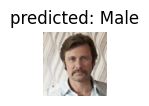

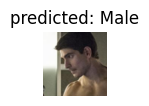

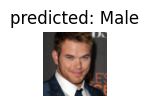

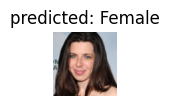

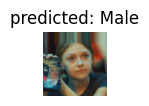

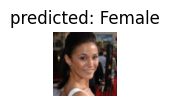

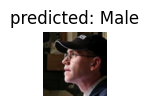

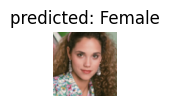

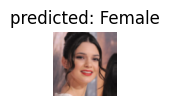

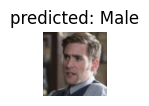

In [22]:
visualize_model(net, num_images=10)